In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.patches as patches
import numpy as np

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# --- read data --- 

path = '/scratch/pchen25/clim680_dataset/MidMiocene/'
file_Pi = 'Mio_Pi/B.MMIOx2_C5_280_WISOon.cam.clim_burdendust_1900_1999.nc'
file_Mio = 'Mio_Mio/B.MMIOx2_C5_280_WISOon_aeroZonal.cam.clim_burdendust_100_300.nc'

ds_Pi = xr.open_mfdataset(path+file_Pi)
ds_Mio = xr.open_mfdataset(path+file_Mio)

ds_Pi

<xarray.Dataset>
Dimensions:     (time: 1200, lat: 96, lon: 144, nbnd: 2)
Coordinates:
  * lat         (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon         (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time        (time) object 1900-02-01 00:00:00 ... 2000-01-01 00:00:00
Dimensions without coordinates: nbnd
Data variables:
    BURDENDUST  (time, lat, lon) float32 dask.array<chunksize=(1200, 96, 144), meta=np.ndarray>
    time_bnds   (time, nbnd) object dask.array<chunksize=(1200, 2), meta=np.ndarray>
Attributes:
    Conventions:      CF-1.0
    source:           CAM
    case:             B.MMIOx2_C5_280_WISOon
    title:            UNSET
    logname:          pacosta
    host:             r8i0n31
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     /glade/scratch/pacosta/B.MMIOx2_C5_280_WISOon/run/B.MMI...
    topography_file:  /glade/work/pacosta/PaleoBC/heroldn/gx1vMIO/cami_bnd_to...
    history:          Sun Nov 12 20:18:00 2023: ncrcat ./B.MMIOx2_C5_280_WISO...
    NCO:              netCDF Operators version 5.1.4 (Homepage = http://nco.s...

In [3]:
# input LANDFRAC

path = '/scratch/pchen25/clim680_dataset/MidMiocene/atm/'
file_name = 'B.MMIOx2_C5_280_WISOon_ANN_concat.nc'
ds = xr.open_dataset(path+file_name)

var = 'LANDFRAC'
mask = ds[var][0,:,:]
data = ds['TS']

data, lons = add_cyclic_point(data, coord=ds['lon'])
mask, mask_lons = add_cyclic_point(mask, coord=ds['lon'])

In [4]:
# --- (var.): dust ---

var = 'BURDENDUST'
dust_Pi = ds_Pi[var]
dust_Mio = ds_Mio[var][1200:2400,:,:]

lon = ds_Pi['lon']
lat = ds_Pi['lat']

# --- Anomaly ---
dust_Pi_gb = dust_Pi.groupby('time.month')
dust_Mio_gb = dust_Mio.groupby('time.month')
dust_Pi_anom = dust_Pi_gb - dust_Pi_gb.mean(dim='time')
dust_Mio_anom = dust_Mio_gb - dust_Mio_gb.mean(dim='time')

/home/pchen25/.conda/envs/clim_data/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 100 times more chunks
  return self.array[key]
/home/pchen25/.conda/envs/clim_data/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 100 times more chunks
  return self.array[key]


In [5]:
BurdenDust_Pi_mean = dust_Pi.mean(dim=('time'))
BurdenDust_Mio_mean = dust_Mio.mean(dim=('time'))
BurdenDust_Diff_mean = BurdenDust_Mio_mean - BurdenDust_Pi_mean

BurdenDust_Pi_mean_new, lons = add_cyclic_point(BurdenDust_Pi_mean, coord=ds['lon'])
BurdenDust_Mio_mean_new, lons = add_cyclic_point(BurdenDust_Mio_mean, coord=ds['lon'])
BurdenDust_Diff_mean_new, lons = add_cyclic_point(BurdenDust_Diff_mean, coord=ds['lon'])

BurdenDust_2D = [BurdenDust_Mio_mean_new, BurdenDust_Pi_mean_new, BurdenDust_Diff_mean_new]

/home/pchen25/.conda/envs/clim_data/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: Log scale: values of z <= 0 have been masked
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


Text(0.5, 0.65, 'Dust Burden [kg/m^2]')

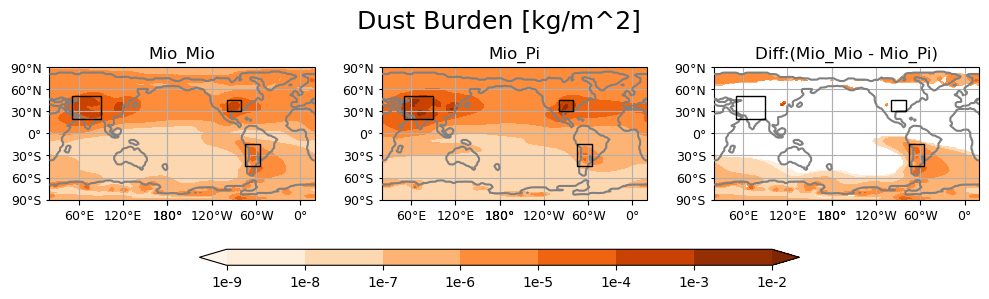

In [6]:
# Function of Plotting

data_title = 'Dust Burden [kg/m^2]'
plot_name = 'plot_dust_burden_pattern'
levels = [1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2] # manually set the levels we want to see here
levels_ticks = ['1e-9','1e-8','1e-7','1e-6','1e-5','1e-4','1e-3','1e-2']

dust_species = ['Mio_Mio','Mio_Pi','Diff:(Mio_Mio - Mio_Pi)']
    
# Define the figure and each axis for the 4 rows and 3 columns
fig, axs = plt.subplots(nrows=1,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=200)},
                        figsize=(12,8))
    
# Set Width / Height padding between subplots, expressed as a fraction of the subplot width
fig.subplots_adjust(wspace=0.25, hspace=0.05) 
    
# axs is a 2 dimensional array of `GeoAxes`
# flatten it into a 1-D array
axs=axs.flatten()

# Loop over all of the months and plot
for i,m in enumerate(dust_species):
        
    # Contour plot
    cs=axs[i].contourf(lons, ds_Pi['lat'], BurdenDust_2D[i],
                       levels = levels,
                       locator=ticker.LogLocator(),
                       transform = ccrs.PlateCarree(),
                       #cmap=cmap,extend='max')
                       cmap='Oranges',extend='both')

    # Longitude labels
    axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()  
    axs[i].xaxis.set_major_formatter(lon_formatter)  # set the format of xticks_label
    axs[i].tick_params(axis='y', size=2)             # set xtick parameters
    for xlabel in axs[i].get_xticklabels():          # set xticks_label
        xlabel.set_fontsize(9)        

    # Latitude labels
    axs[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter)  # set the format of yticks_label
    axs[i].tick_params(axis='y', size=2)             # set ytick parameters
    for ylabel in axs[i].get_yticklabels():          # set yticks_label
        ylabel.set_fontsize(9)        
    
    # Title each subplot with the name of the month
    axs[i].set_title(dust_species[i])
        
    # Add gridlines
    axs[i].gridlines(zorder=2)
        
    cs_mask = axs[i].contour(lons,ds_Pi['lat'],mask,[0.1,1],
                             transform = ccrs.PlateCarree(),
                             #colors='grey',alpha=1.0, zorder=3)
                             linestyles='solid', colors='grey', zorder=3)
    
    # Add patches
    # ( (x,y)[center: (200,0)], width, height, ...)
    rect1 = patches.Rectangle((-150, 20), 40, 30, lw = 1, edgecolor = 'k', facecolor = 'none', zorder=4)  # (50~90E; 20~50N)
    rect2 = patches.Rectangle((60, 30), 20, 15, lw = 1, edgecolor = 'k', facecolor = 'none', zorder=4)  # (100~80W; 30~45N)
    rect3 = patches.Rectangle((85, -45), 20, 30, lw = 1, edgecolor = 'k', facecolor = 'none', zorder=4)  # (75~55W; 15~45S)
    axs[i].add_patch(rect1)
    axs[i].add_patch(rect2)
    axs[i].add_patch(rect3)
    
        
# Add colorbar
cax  = fig.add_axes([0.25, 0.33, 0.5, 0.02])    # set the [x0, y0, width, height] of the colorbar
CB   = plt.colorbar(cs, cax = cax, orientation='horizontal',
                    format=mticker.FixedFormatter(levels_ticks))
#CB.set_label('', rotation=0, fontsize=12)

# Add title
plt.suptitle(data_title, y=0.65, fontsize=18)
# fig.savefig(plot_name+'.png')

In [7]:
# select domain

# (domain 1) - (50~90E; 20~50N)
dust_Pi_box1 = dust_Pi_anom.sel(lat=slice(20,50),lon=slice(50,90))
dust_Mio_box1 = dust_Mio_anom.sel(lat=slice(20,50),lon=slice(50,90))

weights = np.cos(np.deg2rad(dust_Pi_box1.lat))
index1_Pi = dust_Pi_box1.weighted(weights).mean(dim=['lon','lat'])
index1_Mio = dust_Mio_box1.weighted(weights).mean(dim=['lon','lat'])

# (domain 2) - (100~80W; 30~45N)
dust_Pi_box2 = dust_Pi_anom.sel(lat=slice(30,45),lon=slice(260,280))
dust_Mio_box2 = dust_Mio_anom.sel(lat=slice(30,45),lon=slice(260,280))

weights = np.cos(np.deg2rad(dust_Pi_box2.lat))
index2_Pi = dust_Pi_box2.weighted(weights).mean(dim=['lon','lat'])
index2_Mio = dust_Mio_box2.weighted(weights).mean(dim=['lon','lat'])

# (domain 3) - (75~55W; 15~45S)
dust_Pi_box3 = dust_Pi_anom.sel(lat=slice(-45,-15),lon=slice(285,305))
dust_Mio_box3 = dust_Mio_anom.sel(lat=slice(-45,-15),lon=slice(285,305))

weights = np.cos(np.deg2rad(dust_Pi_box3.lat))
index3_Pi = dust_Pi_box3.weighted(weights).mean(dim=['lon','lat'])
index3_Mio = dust_Mio_box3.weighted(weights).mean(dim=['lon','lat'])

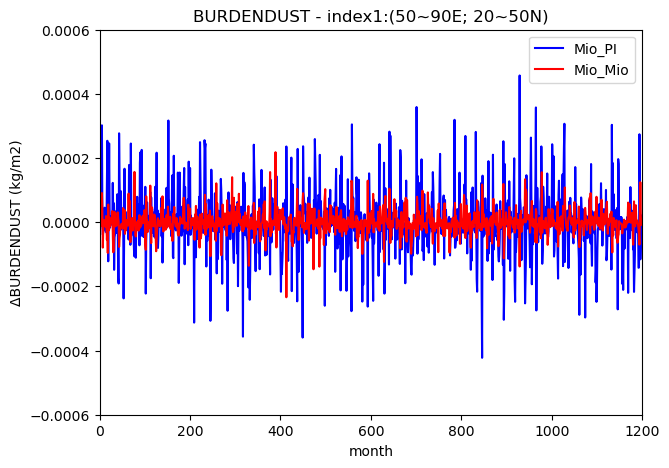

In [8]:
# Create the plot - index1
fig, ax1 = plt.subplots()
fig.set_size_inches(7,5)

ax1.set_xlabel('month')
ax1.set_ylabel('ΔBURDENDUST (kg/m2)')
ax1.plot(np.arange(1,1201,1), index1_Pi, color='b')
ax1.plot(np.arange(1,1201,1), index1_Mio, color='r')

plt.title('BURDENDUST - index1:(50~90E; 20~50N)')
plt.xlim(0, 1200)
plt.ylim(-0.0006, 0.0006)
plt.legend(['Mio_PI', 'Mio_Mio'])

# Show the plot
plt.show()

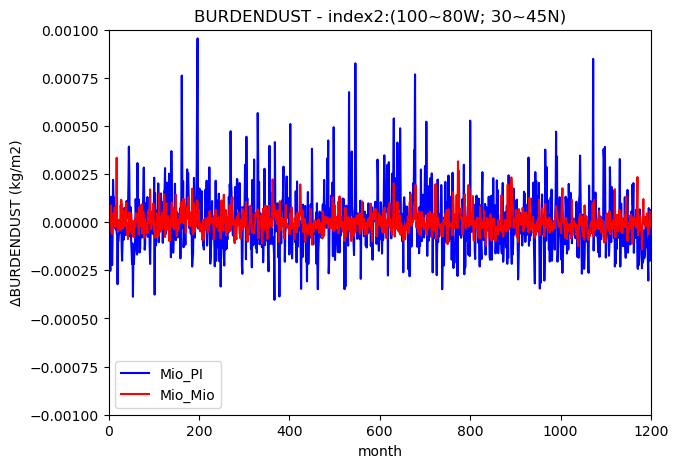

In [9]:
# Create the plot - index2
fig, ax1 = plt.subplots()
fig.set_size_inches(7,5)

ax1.set_xlabel('month')
ax1.set_ylabel('ΔBURDENDUST (kg/m2)')
ax1.plot(np.arange(1,1201,1), index2_Pi, color='b')
ax1.plot(np.arange(1,1201,1), index2_Mio, color='r')

plt.title('BURDENDUST - index2:(100~80W; 30~45N)')
plt.xlim(0, 1200)
plt.ylim(-0.001, 0.001)
plt.legend(['Mio_PI', 'Mio_Mio'])

# Show the plot
plt.show()

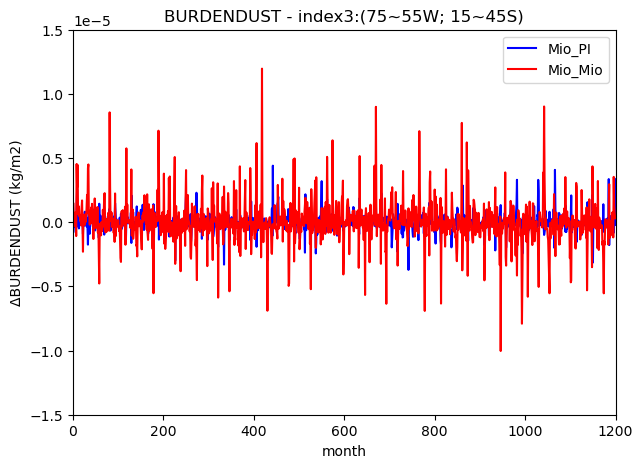

In [10]:
# Create the plot - index3
fig, ax1 = plt.subplots()
fig.set_size_inches(7,5)

ax1.set_xlabel('month')
ax1.set_ylabel('ΔBURDENDUST (kg/m2)')
ax1.plot(np.arange(1,1201,1), index3_Pi, color='b')
ax1.plot(np.arange(1,1201,1), index3_Mio, color='r')

plt.title('BURDENDUST - index3:(75~55W; 15~45S)')
plt.xlim(0, 1200)
plt.ylim(-0.000015, 0.000015)
plt.legend(['Mio_PI', 'Mio_Mio'])

# Show the plot
plt.show()

In [11]:
stddev_index1_Pi = index1_Pi.std().values
stddev_index1_Mio = index1_Mio.std().values
stddev_index2_Pi = index2_Pi.std().values
stddev_index2_Mio = index2_Mio.std().values
stddev_index3_Pi = index3_Pi.std().values
stddev_index3_Mio = index3_Mio.std().values

In [12]:
# --- stddev ---

high_index1_Pi = index1_Pi.where(index1_Pi>=2*stddev_index1_Pi)
low_index1_Pi = index1_Pi.where(index1_Pi<=-2*stddev_index1_Pi)
neutral_index1_Pi = index1_Pi.where(np.logical_and(index1_Pi>-2*stddev_index1_Pi, index1_Pi<2*stddev_index1_Pi))

high_index1_Mio = index1_Mio.where(index1_Mio>=2*stddev_index1_Mio)
low_index1_Mio = index1_Mio.where(index1_Mio<=-2*stddev_index1_Mio)
neutral_index1_Mio = index1_Mio.where(np.logical_and(index1_Mio>-2*stddev_index1_Mio, index1_Mio<2*stddev_index1_Mio))

high_index2_Pi = index2_Pi.where(index2_Pi>=2*stddev_index2_Pi)
low_index2_Pi = index2_Pi.where(index2_Pi<=-2*stddev_index2_Pi)
neutral_index2_Pi = index2_Pi.where(np.logical_and(index2_Pi>-2*stddev_index2_Pi, index2_Pi<2*stddev_index2_Pi))

high_index2_Mio = index2_Mio.where(index2_Mio>=2*stddev_index2_Mio)
low_index2_Mio = index2_Mio.where(index2_Mio<=-2*stddev_index2_Mio)
neutral_index2_Mio = index2_Mio.where(np.logical_and(index2_Mio>-2*stddev_index2_Mio, index2_Mio<2*stddev_index2_Mio))

high_index3_Pi = index3_Pi.where(index3_Pi>=2*stddev_index3_Pi)
low_index3_Pi = index3_Pi.where(index3_Pi<=-2*stddev_index3_Pi)
neutral_index3_Pi = index3_Pi.where(np.logical_and(index3_Pi>-2*stddev_index3_Pi, index3_Pi<2*stddev_index3_Pi))

high_index3_Mio = index3_Mio.where(index3_Mio>=2*stddev_index3_Mio)
low_index3_Mio = index3_Mio.where(index3_Mio<=-2*stddev_index3_Mio)
neutral_index3_Mio = index3_Mio.where(np.logical_and(index3_Mio>-2*stddev_index3_Mio, index3_Mio<2*stddev_index3_Mio))

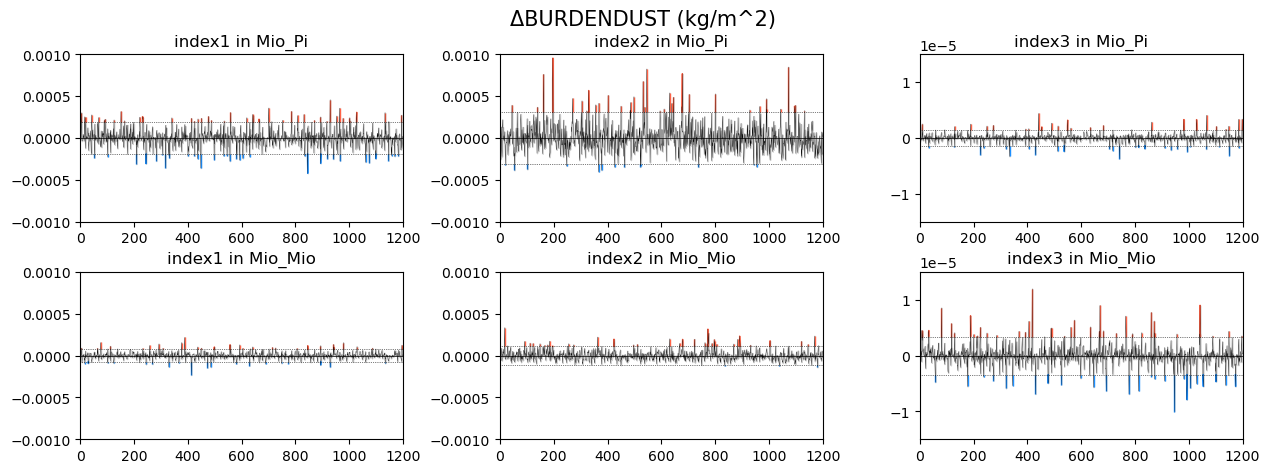

In [13]:
stddev_index = [stddev_index1_Pi, stddev_index2_Pi, stddev_index3_Pi,
                stddev_index1_Mio, stddev_index2_Mio, stddev_index3_Mio]

high_index = [high_index1_Pi, high_index2_Pi, high_index3_Pi,
              high_index1_Mio, high_index2_Mio, high_index3_Mio]

low_index = [low_index1_Pi, low_index2_Pi, low_index3_Pi,
              low_index1_Mio, low_index2_Mio, low_index3_Mio]

indices = [index1_Pi, index2_Pi, index3_Pi,
           index1_Mio, index2_Mio, index3_Mio]

# indices_name = ['index1:(50~90E; 20~50N) in Mio_Pi', 'index2:(100~80W; 30~45N) in Mio_Pi', 'index3:(75~55W; 15~45S) in Mio_Pi', 
                # 'index1:(50~90E; 20~50N) in Mio_Mio', 'index2:(100~80W; 30~45N) in Mio_Mio', 'index3:(75~55W; 15~45S) in Mio_Mio']
indices_name = ['index1 in Mio_Pi', 'index2 in Mio_Pi', 'index3 in Mio_Pi', 
                'index1 in Mio_Mio', 'index2 in Mio_Mio', 'index3 in Mio_Mio']


# Create the plot
fig, ax2 = plt.subplots(nrows=2,ncols=3,
                        figsize=(15, 5))

#flatten axs into a 1-D array (just 3 rows)
ax2 = ax2.flatten()

#Loop over all of the composites and plot
for i,name in enumerate(indices_name):
    
    # ax2[i].set_xlabel('month')
    # ax2[i].set_ylabel('ΔBURDENDUST (kg/m^2)')
    ax2[i].plot(np.arange(1,1201,1), indices[i], color='k', linewidth=0.2)
    
    ax2[i].fill_between(np.arange(1,1201,1), indices[i], color='lightgrey')
    ax2[i].fill_between(np.arange(1,1201,1), high_index[i], y2=2*stddev_index[i], color='tomato')
    ax2[i].fill_between(np.arange(1,1201,1), low_index[i], y2=-2*stddev_index[i], color='dodgerblue')
    
    ax2[i].set_title(name)
    ax2[i].set_xlim(0, 1200)
    
    if i==2 or i==5:
        ax2[i].set_ylim(-0.000015, 0.000015)
    else:
        ax2[i].set_ylim(-0.001, 0.001)
    
    ax2[i].axhline(0, color='black', linewidth=0.5)
    ax2[i].axhline(2*stddev_index[i], color='black', linewidth=0.5, linestyle='dotted')
    ax2[i].axhline(-2*stddev_index[i], color='black', linewidth=0.5, linestyle='dotted')

fig.subplots_adjust(wspace=0.3, hspace=0.3)
plt.suptitle('ΔBURDENDUST (kg/m^2)', y=0.97, fontsize=15) ;

### Read Precipitation & TS

In [16]:
# --- read data --- 

path = '/scratch/pchen25/clim680_dataset/MidMiocene/'
file_Pi2 = 'Mio_Pi/B.MMIOx2_C5_280_WISOon.cam.clim_1900_1999.nc'
file_Mio2 = 'Mio_Mio/B.MMIOx2_C5_280_WISOon_aeroZonal.cam.clim_100_300.nc'

ds_Pi2 = xr.open_dataset(path+file_Pi2)
ds_Mio2 = xr.open_dataset(path+file_Mio2)

ds_Pi2

<xarray.Dataset>
Dimensions:    (time: 1200, lat: 96, lon: 144, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time       (time) object 1900-02-01 00:00:00 ... 2000-01-01 00:00:00
Dimensions without coordinates: nbnd
Data variables:
    PRECC      (time, lat, lon) float32 ...
    PRECL      (time, lat, lon) float32 ...
    TS         (time, lat, lon) float32 ...
    time_bnds  (time, nbnd) object ...
Attributes:
    Conventions:      CF-1.0
    source:           CAM
    case:             B.MMIOx2_C5_280_WISOon
    title:            UNSET
    logname:          pacosta
    host:             r8i0n31
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     /glade/scratch/pacosta/B.MMIOx2_C5_280_WISOon/run/B.MMI...
    topography_file:  /glade/work/pacosta/PaleoBC/heroldn/gx1vMIO/cami_bnd_to...
    history:          Thu Nov  2 18:37:20 2023: ncrcat ./B.MMIOx2_C5_280_WISO...
    NCO:              netCDF Operators version 5.1.4 (Homepage = http://nco.s...

In [17]:
# --- (var.): precipitation ---

precc_Pi = ds_Pi2['PRECC']
precl_Pi = ds_Pi2['PRECL']
prec_Pi = (precc_Pi + precl_Pi)*1000*86400

prec_Pi_clim = prec_Pi.groupby('time.month').mean()
prec_Pi_ano = prec_Pi.groupby('time.month')-prec_Pi_clim

high_prec1_Pi = prec_Pi_ano.sel(time=high_index1_Pi.dropna(dim='time')['time']).mean(dim='time')
low_prec1_Pi = prec_Pi_ano.sel(time=low_index1_Pi.dropna(dim='time')['time']).mean(dim='time')
high_prec2_Pi = prec_Pi_ano.sel(time=high_index2_Pi.dropna(dim='time')['time']).mean(dim='time')
low_prec2_Pi = prec_Pi_ano.sel(time=low_index2_Pi.dropna(dim='time')['time']).mean(dim='time')
high_prec3_Pi = prec_Pi_ano.sel(time=high_index3_Pi.dropna(dim='time')['time']).mean(dim='time')
low_prec3_Pi = prec_Pi_ano.sel(time=low_index3_Pi.dropna(dim='time')['time']).mean(dim='time')


precc_Mio = ds_Mio2['PRECC']
precl_Mio = ds_Mio2['PRECL']
prec_Mio = (precc_Mio + precl_Mio)*1000*86400

prec_Mio_clim = prec_Mio.groupby('time.month').mean()
prec_Mio_ano = prec_Mio.groupby('time.month')-prec_Mio_clim

high_prec1_Mio = prec_Mio_ano.sel(time=high_index1_Mio.dropna(dim='time')['time']).mean(dim='time')
low_prec1_Mio = prec_Mio_ano.sel(time=low_index1_Mio.dropna(dim='time')['time']).mean(dim='time')
high_prec2_Mio = prec_Mio_ano.sel(time=high_index2_Mio.dropna(dim='time')['time']).mean(dim='time')
low_prec2_Mio = prec_Mio_ano.sel(time=low_index2_Mio.dropna(dim='time')['time']).mean(dim='time')
high_prec3_Mio = prec_Mio_ano.sel(time=high_index3_Mio.dropna(dim='time')['time']).mean(dim='time')
low_prec3_Mio = prec_Mio_ano.sel(time=low_index3_Mio.dropna(dim='time')['time']).mean(dim='time')


high_precip = [high_prec1_Pi, high_prec2_Pi, high_prec3_Pi,
               high_prec1_Mio, high_prec2_Mio, high_prec3_Mio]
low_precip = [low_prec1_Pi, low_prec2_Pi, low_prec3_Pi,
               low_prec1_Mio, low_prec2_Mio, low_prec3_Mio]

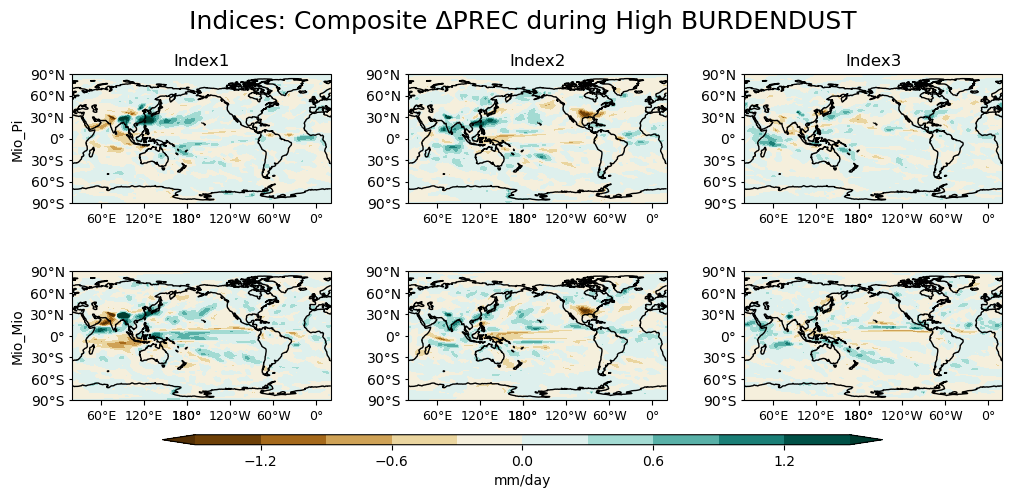

In [18]:
labels=['Index1','Index2', 'Index3','','', '']
clevs = np.linspace(-1.5, 1.5, 11)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=2,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=200)},
                        figsize=(12, 5))

#flatten axs into a 1-D array (just 3 rows)
axs = axs.flatten()

#Loop over all of the composites and plot
for i,m in enumerate(high_precip):

        # Select the season
        data = high_precip[i]

        # Add the cyclic point
        data,lons = add_cyclic_point(data, coord=high_precip[i]['lon'])

        # Contour plot
        cs=axs[i].contourf(lons,high_precip[i]['lat'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='BrBG',extend='both')

        # Longitude labels
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)
        axs[i].tick_params(axis='y', size=2)             # set xtick parameters
        for xlabel in axs[i].get_xticklabels():          # set xticks_label
            xlabel.set_fontsize(9)
        
        # Latitude labels
        axs[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        
        # Title each subplot with the name of the season
        axs[i].set_title(labels[i])

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
        if i==0:
            axs[i].set_ylabel('Mio_Pi')
        elif i==3:
            axs[i].set_ylabel('Mio_Mio')
        else:
            axs[i].set_ylabel('')
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
# fig.subplots_adjust(bottom=0.25, top=0.65, left=0.05, right=0.95, wspace=0.3, hspace=0.1)
fig.subplots_adjust(wspace=0.3, hspace=0.05)

# Add a colorbar
cax  = fig.add_axes([0.2, 0.08, 0.6, 0.02])    # set the [x0, y0, width, height] of the colorbar
CB   = plt.colorbar(cs, cax = cax, orientation='horizontal', label='mm/day')

# Add a big title at the top
plt.suptitle('Indices: Composite ΔPREC during High BURDENDUST', y=0.95, fontsize=18) ;   

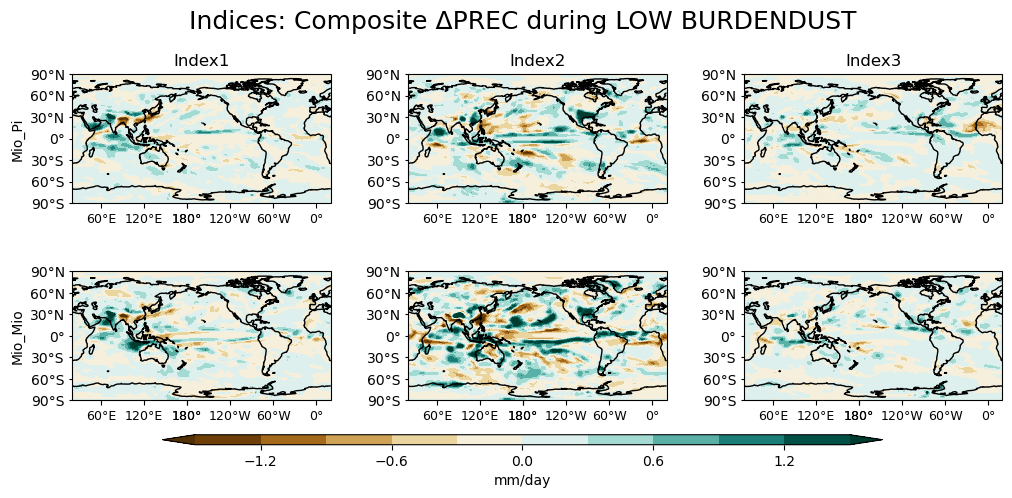

In [19]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=2,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=200)},
                        figsize=(12, 5))

#flatten axs into a 1-D array (just 3 rows)
axs = axs.flatten()

#Loop over all of the composites and plot
for i,m in enumerate(low_precip):

        # Select the season
        data = low_precip[i]

        # Add the cyclic point
        data,lons = add_cyclic_point(data, coord=low_precip[i]['lon'])

        # Contour plot
        cs=axs[i].contourf(lons,low_precip[i]['lat'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='BrBG',extend='both')

        # Longitude labels
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)
        axs[i].tick_params(axis='y', size=2)             # set xtick parameters
        for xlabel in axs[i].get_xticklabels():          # set xticks_label
            xlabel.set_fontsize(9)
        
        # Latitude labels
        axs[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)
        
        # Title each subplot with the name of the season
        axs[i].set_title(labels[i])

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
        if i==0:
            axs[i].set_ylabel('Mio_Pi')
        elif i==3:
            axs[i].set_ylabel('Mio_Mio')
        else:
            axs[i].set_ylabel('')
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
# fig.subplots_adjust(bottom=0.25, top=0.65, left=0.05, right=0.95, wspace=0.3, hspace=0.1)
fig.subplots_adjust(wspace=0.3, hspace=0.05)

# Add a colorbar
cax  = fig.add_axes([0.2, 0.08, 0.6, 0.02])    # set the [x0, y0, width, height] of the colorbar
CB   = plt.colorbar(cs, cax = cax, orientation='horizontal', label='mm/day')

# Add a big title at the top
plt.suptitle('Indices: Composite ΔPREC during LOW BURDENDUST', y=0.95, fontsize=18) ;   

In [20]:
# --- (var.): TS ---

TS_Pi = ds_Pi2['TS']

TS_Pi_clim = TS_Pi.groupby('time.month').mean()
TS_Pi_ano = TS_Pi.groupby('time.month')-TS_Pi_clim

high_TS1_Pi = TS_Pi_ano.sel(time=high_index1_Pi.dropna(dim='time')['time']).mean(dim='time')
low_TS1_Pi = TS_Pi_ano.sel(time=low_index1_Pi.dropna(dim='time')['time']).mean(dim='time')
high_TS2_Pi = TS_Pi_ano.sel(time=high_index2_Pi.dropna(dim='time')['time']).mean(dim='time')
low_TS2_Pi = TS_Pi_ano.sel(time=low_index2_Pi.dropna(dim='time')['time']).mean(dim='time')
high_TS3_Pi = TS_Pi_ano.sel(time=high_index3_Pi.dropna(dim='time')['time']).mean(dim='time')
low_TS3_Pi = TS_Pi_ano.sel(time=low_index3_Pi.dropna(dim='time')['time']).mean(dim='time')


TS_Mio = ds_Mio2['TS']

TS_Mio_clim = TS_Mio.groupby('time.month').mean()
TS_Mio_ano = TS_Mio.groupby('time.month')-TS_Mio_clim

high_TS1_Mio = TS_Mio_ano.sel(time=high_index1_Mio.dropna(dim='time')['time']).mean(dim='time')
low_TS1_Mio = TS_Mio_ano.sel(time=low_index1_Mio.dropna(dim='time')['time']).mean(dim='time')
high_TS2_Mio = TS_Mio_ano.sel(time=high_index2_Mio.dropna(dim='time')['time']).mean(dim='time')
low_TS2_Mio = TS_Mio_ano.sel(time=low_index2_Mio.dropna(dim='time')['time']).mean(dim='time')
high_TS3_Mio = TS_Mio_ano.sel(time=high_index3_Mio.dropna(dim='time')['time']).mean(dim='time')
low_TS3_Mio = TS_Mio_ano.sel(time=low_index3_Mio.dropna(dim='time')['time']).mean(dim='time')


high_TS = [high_TS1_Pi, high_TS2_Pi, high_TS3_Pi,
               high_TS1_Mio, high_TS2_Mio, high_TS3_Mio]
low_TS = [low_TS1_Pi, low_TS2_Pi, low_TS3_Pi,
               low_TS1_Mio, low_TS2_Mio, low_TS3_Mio]

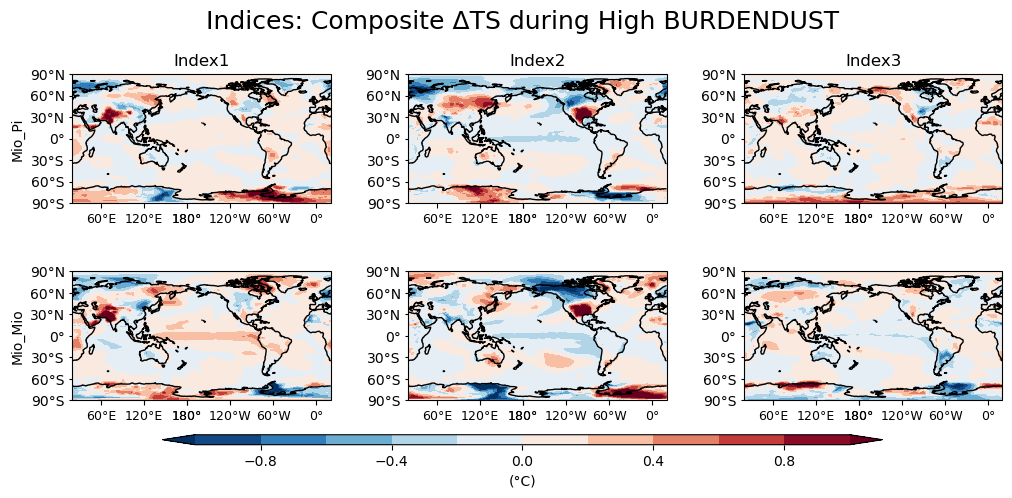

In [21]:
labels=['Index1','Index2', 'Index3','','', '']
clevs = np.linspace(-1.0, 1.0, 11)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=2,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=200)},
                        figsize=(12, 5))

#flatten axs into a 1-D array (just 3 rows)
axs = axs.flatten()

#Loop over all of the composites and plot
for i,m in enumerate(high_TS):

        # Select the season
        data = high_TS[i]

        # Add the cyclic point
        data,lons = add_cyclic_point(data, coord=high_TS[i]['lon'])

        # Contour plot
        cs=axs[i].contourf(lons,high_TS[i]['lat'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='RdBu_r',extend='both')

        # Longitude labels
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)
        axs[i].tick_params(axis='y', size=2)             # set xtick parameters
        for xlabel in axs[i].get_xticklabels():          # set xticks_label
            xlabel.set_fontsize(9)
        
        # Latitude labels
        axs[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        
        # Title each subplot with the name of the season
        axs[i].set_title(labels[i])

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
        if i==0:
            axs[i].set_ylabel('Mio_Pi')
        elif i==3:
            axs[i].set_ylabel('Mio_Mio')
        else:
            axs[i].set_ylabel('')
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
# fig.subplots_adjust(bottom=0.25, top=0.65, left=0.05, right=0.95, wspace=0.3, hspace=0.1)
fig.subplots_adjust(wspace=0.3, hspace=0.05)

# Add a colorbar
cax  = fig.add_axes([0.2, 0.08, 0.6, 0.02])    # set the [x0, y0, width, height] of the colorbar
CB   = plt.colorbar(cs, cax = cax, orientation='horizontal', label='(°C)')

# Add a big title at the top
plt.suptitle('Indices: Composite ΔTS during High BURDENDUST', y=0.95, fontsize=18) ;   

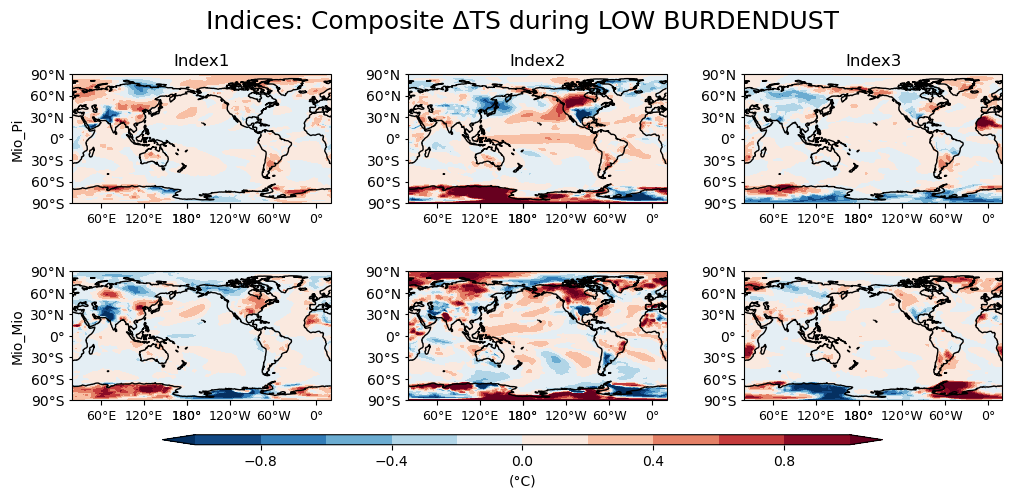

In [22]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=2,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=200)},
                        figsize=(12, 5))

#flatten axs into a 1-D array (just 3 rows)
axs = axs.flatten()

#Loop over all of the composites and plot
for i,m in enumerate(low_TS):

        # Select the season
        data = low_TS[i]

        # Add the cyclic point
        data,lons = add_cyclic_point(data, coord=low_TS[i]['lon'])

        # Contour plot
        cs=axs[i].contourf(lons,low_TS[i]['lat'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='RdBu_r',extend='both')

        # Longitude labels
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)
        axs[i].tick_params(axis='y', size=2)             # set xtick parameters
        for xlabel in axs[i].get_xticklabels():          # set xticks_label
            xlabel.set_fontsize(9)
        
        # Latitude labels
        axs[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)
        
        # Title each subplot with the name of the season
        axs[i].set_title(labels[i])

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
        if i==0:
            axs[i].set_ylabel('Mio_Pi')
        elif i==3:
            axs[i].set_ylabel('Mio_Mio')
        else:
            axs[i].set_ylabel('')
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
# fig.subplots_adjust(bottom=0.25, top=0.65, left=0.05, right=0.95, wspace=0.3, hspace=0.1)
fig.subplots_adjust(wspace=0.3, hspace=0.05)

# Add a colorbar
cax  = fig.add_axes([0.2, 0.08, 0.6, 0.02])    # set the [x0, y0, width, height] of the colorbar
CB   = plt.colorbar(cs, cax = cax, orientation='horizontal', label='(°C)')

# Add a big title at the top
plt.suptitle('Indices: Composite ΔTS during LOW BURDENDUST', y=0.95, fontsize=18) ;   